# Tutorial: Analysis of Water Distribution Networks

## Introduction
This tutorial explores the application of `pyrocs` functions to analysis on water distribution networks. The systems that distribute drinking water (pipes, pumps, tanks, and water treatment facilities) are commonly modelled with a graph structure. This graph structure paired with detailed simulations can provide insights on various aspects of the underlying system. 

In what follows, we 1) compare two common benchmarking networks known as Net3 and Net6 using `pyrocs` metrics to hypothesize about the systems' response to a disruptive event (pipe breakage), 2) run pressure simulations of the system before and after a disruptive event, and 3) use `pyrocs` metrics to evaluate the systems' response to the disruptive event.

The Water Network Tool for Resilience (WNTR) is used to carry out the water network related analyses and must be installed prior to running the notebook. Installation instructions can be found on the [WNTR documentation](https://usepa.github.io/WNTR/installation.html).

In [1]:
import wntr
import pyrocs
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import time

In [2]:
# data associated to each water network model will be kept in these dictionaries
Net3_dict = dict()
Net3_dict["name"] = "Net3"
Net6_dict = dict()
Net6_dict["name"] = "Net6"


In [3]:
Net3_path = "Net3.inp"
Net6_path = "Net6.inp"

Net3_dict["wn"] = wntr.network.WaterNetworkModel(Net3_path)
Net6_dict["wn"] = wntr.network.WaterNetworkModel(Net6_path)

wn_dict_list = [Net3_dict, Net6_dict]

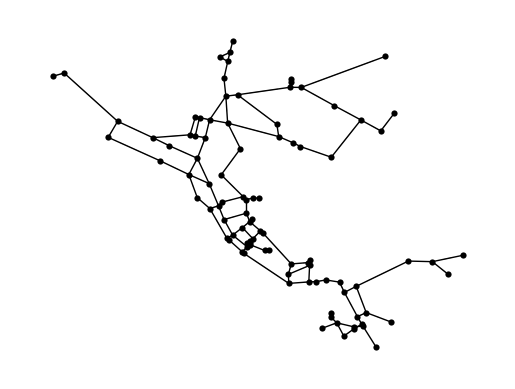

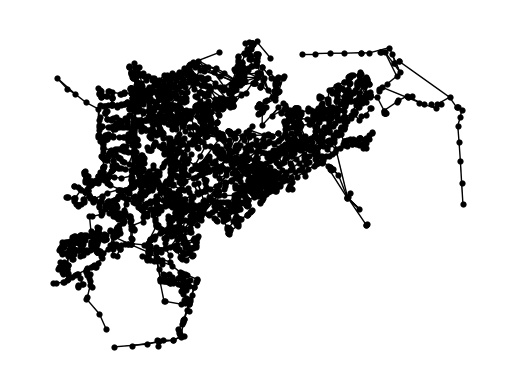

In [4]:
for wn_dict in wn_dict_list:
    wntr.graphics.plot_network(wn_dict["wn"])


Extract graph structure from water network models to run pyrocs functions.

In [5]:
for wn_dict in wn_dict_list:
    wn_dict["graph"] = nx.Graph(wn_dict["wn"].to_graph())
    wn_dict["adj_matrix"] = nx.adjacency_matrix(wn_dict["graph"])


## Use GRC to formulate hypothesis

Compute GRC as a measure of network resilience to inform a hypothesis on network response to disruption.

NOTE: This computation is timed to help quantify the computational scaling of pyrocs functions.

In [6]:
for wn_dict in wn_dict_list:
    start = time.time()
    wn_dict["grc"] = pyrocs.complex_systems.grc(wn_dict["adj_matrix"], directed=False)
    end = time.time()
    delta = end - start
    print(f"GRC for {wn_dict["name"]}: ", wn_dict["grc"])
    print(f"Time to compute GRC for {wn_dict["name"]}: ", delta, "(s)")
    print(f"# of edges for {wn_dict["name"]}: ", len(wn_dict["graph"].edges()))
    print(f"# of nodes for {wn_dict["name"]}: ", len(wn_dict["graph"].nodes()))


<class 'networkx.utils.decorators.argmap'> compilation 36:3: FutureWarning: 

shortest_path will return an iterator that yields
(node, path) pairs instead of a dictionary when source
and target are unspecified beginning in version 3.5

To keep the current behavior, use:

	dict(nx.shortest_path(G))


GRC for Net3:  0.061047639690378526
Time to compute GRC for Net3:  0.019777297973632812 (s)
# of edges for Net3:  119
# of nodes for Net3:  97
GRC for Net6:  0.01626652997371188
Time to compute GRC for Net6:  37.876359939575195 (s)
# of edges for Net6:  3830
# of nodes for Net6:  3356


The value of GRC is much higher for Net3 than Net6 (approximately 4x). Based on this computation, we expect Net3 to have a higher level of hierarchy and therefore to have a higher resilience to disruption.

## Run Hydraulic Simulations
For each network, two hydraulic simulations are carried out. The first is a **baseline** simulation which represents the typical functioning of the system. The second is a **disruption** simulation which represents the system's behavior in response to a disruptive scenario. The disruptive scenario chosen for this notebook is to close a pipe that connects a reservoir to the rest of the system. This effectively removes a source of water from the system, which will result in pressure loss across the system. 

Run baseline hydraulics and plot resulting pressures.

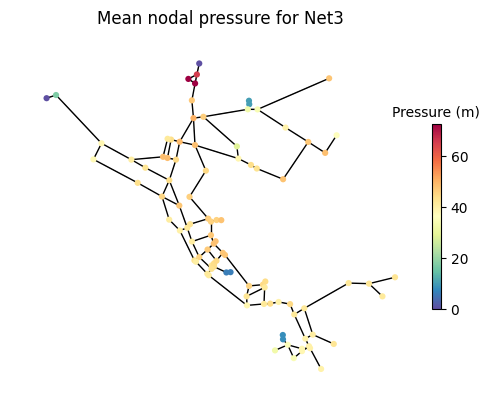

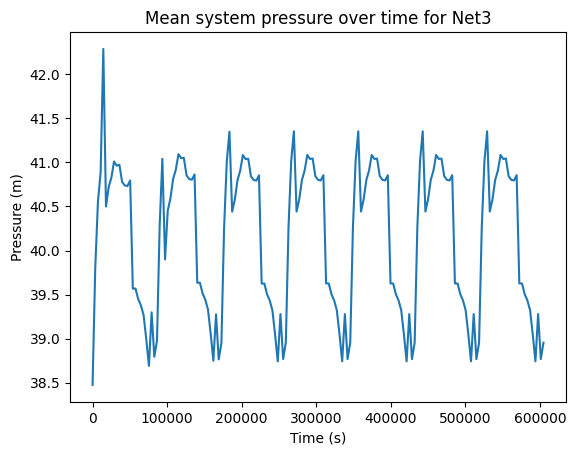

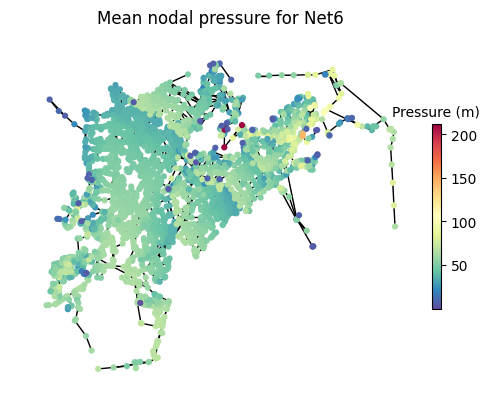

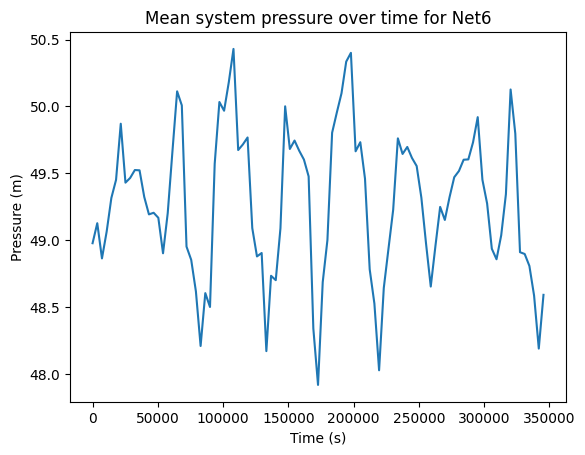

In [7]:
for wn_dict in wn_dict_list:
    sim = wntr.sim.EpanetSimulator(wn_dict["wn"])
    wn_dict["baseline_results"] = sim.run_sim()
    wn_dict["baseline_pressure"] = wn_dict["baseline_results"].node["pressure"]
    wntr.graphics.plot_network(
        wn_dict["wn"], 
        title=f"Mean nodal pressure for {wn_dict["name"]}", 
        node_colorbar_label="Pressure (m)",
        node_attribute=wn_dict["baseline_pressure"].mean(axis=0))
    
    ax = wn_dict["baseline_pressure"].mean(axis=1).plot()
    ax.set_title(f"Mean system pressure over time for {wn_dict["name"]}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Pressure (m)")

Run disruption simulation and plot resulting pressures.
Networks are disrupted by closing a pipe that connects the main reservoir to the network.

In [8]:
Net3_dict["reservoir_pipes"] = ["329", "101"]
Net6_dict["reservoir_pipes"] = ["LINK-0"]

Plot pipes that will be closed for the disruption.

In [9]:
# for wn_dict in wn_dict_list:
#     wntr.graphics.plot_network(wn_dict["wn"], title=f"{wn_dict["name"]} pipe closures", node_size=0, link_attribute=[wn_dict["reservoir_pipe"]])

Run the disruption simulation.

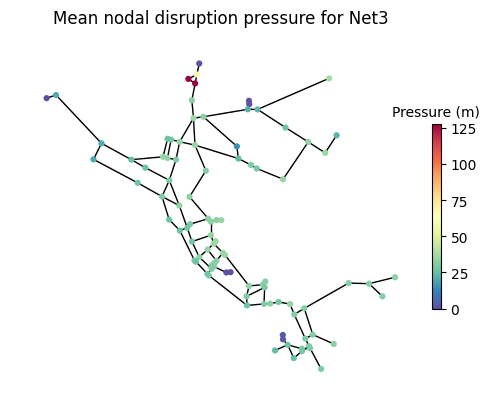

/home/klbonne/miniconda3/envs/pyrocs/lib/python3.12/site-packages/wntr/epanet/io.py:2769: UserWarning: Simulation did not converge at time 20:00:00.
  warnings.warn('Simulation did not converge at time ' + self._get_time(t) + '.')


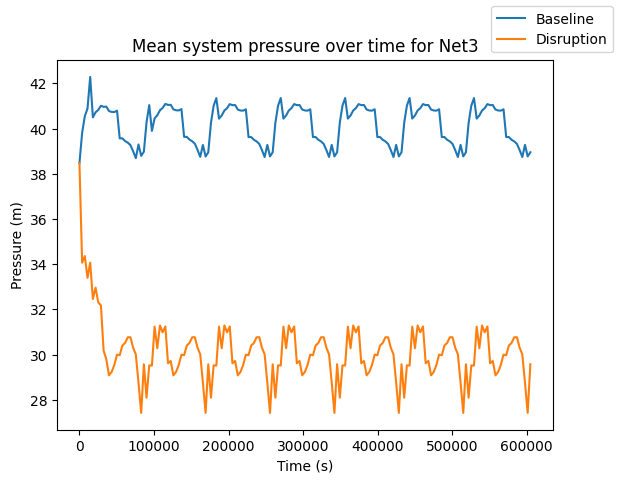

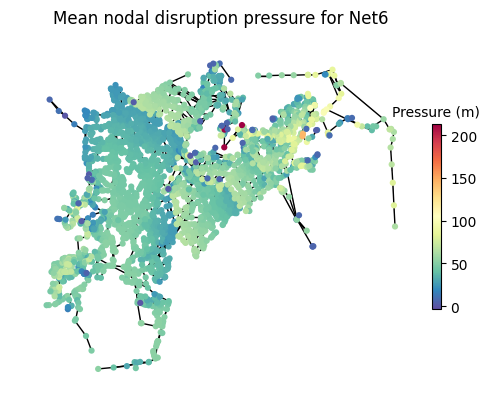

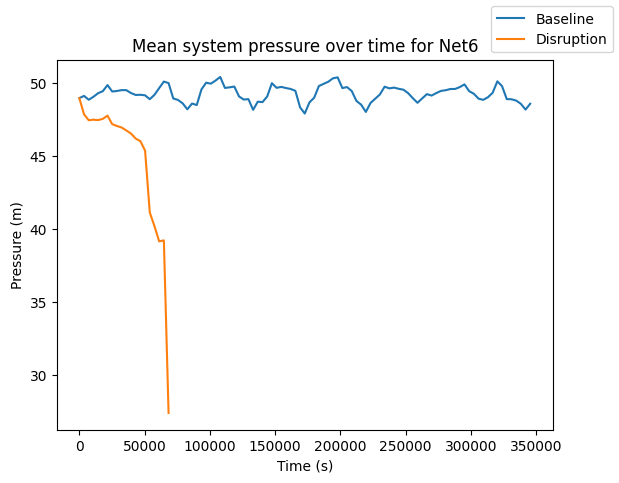

In [10]:
for wn_dict in wn_dict_list:
    wn = wn_dict["wn"]
    wn.reset_initial_values()
    
    for pipe_name in wn_dict["reservoir_pipes"]:
        pipe = wn.get_link(pipe_name)
        
        act = wntr.network.controls.ControlAction(pipe, 'status', 
                                                wntr.network.LinkStatus.Closed)
        cond = wntr.network.controls.SimTimeCondition(wn_dict["wn"], '=', '1:00:00')
        ctrl = wntr.network.controls.Control(cond, act)
        
        wn.add_control('close pipe ' + pipe_name, ctrl)
        
    sim = wntr.sim.EpanetSimulator(wn)
    wn_dict["disruption_results"] = sim.run_sim()
    wn_dict["disruption_pressure"] = wn_dict["disruption_results"].node["pressure"]
    
    for pipe_name in wn_dict["reservoir_pipes"]:
        wn.remove_control('close pipe ' + pipe_name)
    
    wntr.graphics.plot_network(
        wn_dict["wn"], 
        title=f"Mean nodal disruption pressure for {wn_dict["name"]}", 
        node_colorbar_label="Pressure (m)",
        node_attribute=wn_dict["disruption_pressure"].mean(axis=0))
    
    fig, ax = plt.subplots()
    wn_dict["baseline_pressure"].mean(axis=1).plot(ax=ax, label="Baseline")
    wn_dict["disruption_pressure"].mean(axis=1).plot(ax=ax, label="Disruption")
    ax.set_title(f"Mean system pressure over time for {wn_dict["name"]}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Pressure (m)")
    fig.legend()


Due to the lack of water availability in the system, the disruption simulation for Net6 fails after approximately 20 hours. To account for this and allow for futher analysis, the baseline simulation is truncated to the time period that was able to be simulated for the disruption.

In [11]:
print("Number of timesteps in disruption results:", len(Net6_dict["disruption_pressure"]))
print("Number of timesteps in baseline results before processing:", len(Net6_dict["baseline_pressure"]))
Net6_dict["baseline_pressure"] = Net6_dict["baseline_pressure"].loc[wn_dict["disruption_pressure"].index]
print("Number of timesteps in baseline results after processing:", len(Net6_dict["baseline_pressure"]))


Number of timesteps in disruption results: 20
Number of timesteps in baseline results before processing: 97
Number of timesteps in baseline results after processing: 20


## Compare results using pyrocs

evaluation of pressure differences
- kld <-- single value
- ntr <-- timeseries information
- mutual information (measure of similarity) or affinity

start with averages


### Compute KLD
Kullback Liebler Divergence measures the similarity between two distributions. For our purposes, we will compare the baseline pressure distribution to the disruption pressure distribution. This gives us a measurement of how much the system's behavior diverges from typical operation when the disruption occurs. The distributions are formed by looking at the normalized, mean pressure across the time steps of simulation.

Net3  KL Value:  0.0015083118
Net6  KL Value:  0.011644177


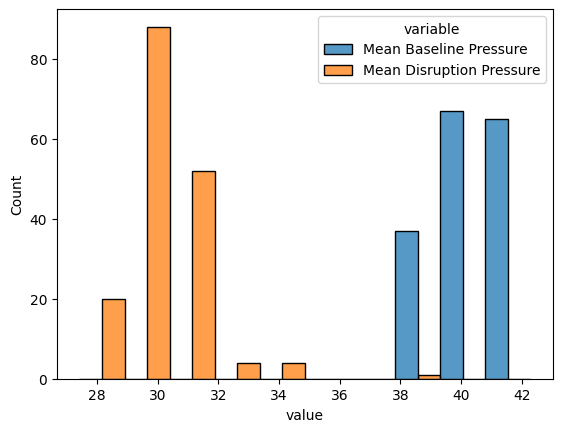

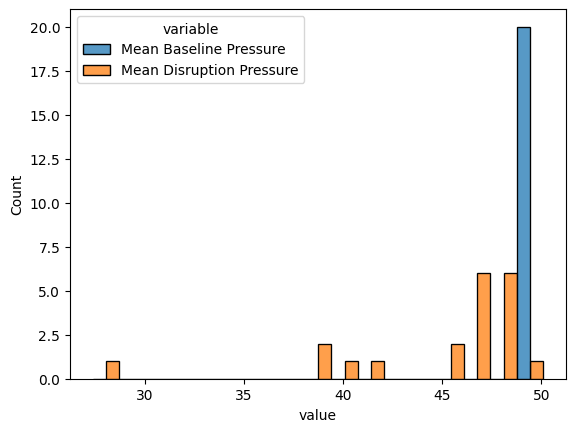

In [22]:
#TODO plot histograms for each network together (might need seaborn)
for wn_dict in wn_dict_list:
    fig, ax = plt.subplots()
    seaborn_df = pd.DataFrame(index=wn_dict["baseline_pressure"].index)
    seaborn_df["Mean Baseline Pressure"] = wn_dict["baseline_pressure"].mean(axis=1)
    seaborn_df["Mean Disruption Pressure"] = wn_dict["disruption_pressure"].mean(axis=1)
    seaborn_df = seaborn_df.melt()
    sns.histplot(seaborn_df, x="value", hue="variable",multiple="dodge", ax=ax)
    
    # normalize pressure
    normalized_baseline = wn_dict["baseline_pressure"].loc[wn_dict["disruption_pressure"].index].mean(axis=1) / wn_dict["baseline_pressure"].loc[wn_dict["disruption_pressure"].index].mean(axis=1).sum()
    normalized_disruption = wn_dict["disruption_pressure"].loc[wn_dict["disruption_pressure"].index].mean(axis=1) / wn_dict["disruption_pressure"].loc[wn_dict["disruption_pressure"].index].mean(axis=1).sum()
    kl_value = pyrocs.information_theory.kl_divergence(normalized_baseline, normalized_disruption)
    print(wn_dict["name"], " KL Value: ", kl_value)

### Compute Mutual Information


MI is computed for the sequence of mean system pressure across time between baseline and disruption.
Interpretation...?

In [23]:

for wn_dict in wn_dict_list:
    mi_value = pyrocs.information_theory.mutual_info(wn_dict["baseline_pressure"].mean(), wn_dict["disruption_pressure"].mean())
    print(wn_dict["name"], " MI Value: ", mi_value)
    

Net3  MI Value:  6.517438615383003
Net6  MI Value:  11.696582490605405


MI is computed for the sequence of mean pressure across time at each node between baseline and disruption.
Interpretation...?

In [14]:

for wn_dict in wn_dict_list:
    mi_value = pyrocs.information_theory.mutual_info(wn_dict["baseline_pressure"].mean(axis=1), wn_dict["disruption_pressure"].mean(axis=1))
    print(wn_dict["name"], " MI Value: ", mi_value)

Net3  MI Value:  4.879123883471844
Net6  MI Value:  4.321928094887362


Compute NTR.

/home/klbonne/repos/pyrocs/pyrocs/information_theory/kl_divergence.py:40: RuntimeWarning: divide by zero encountered in divide
  ratio = p / q
/home/klbonne/repos/pyrocs/pyrocs/information_theory/kl_divergence.py:40: RuntimeWarning: invalid value encountered in divide
  ratio = p / q
/home/klbonne/miniconda3/envs/pyrocs/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/klbonne/miniconda3/envs/pyrocs/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/klbonne/repos/pyrocs/pyrocs/information_theory/kl_divergence.py:123: RuntimeWarning: invalid value encountered in scalar subtract
  resonances.append(novelty - transience)


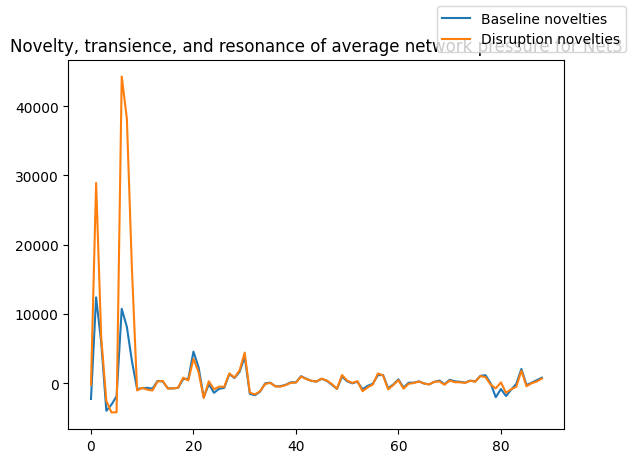

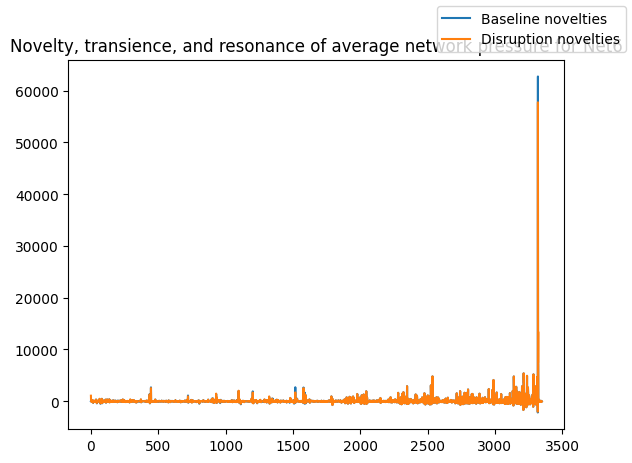

In [15]:
window_size = 3

for wn_dict in wn_dict_list:
    fig, ax = plt.subplots()
    
    novelties, transiences, resonances = pyrocs.information_theory.novelty_transience_resonance(wn_dict["baseline_pressure"].values.T, window=window_size)
    ax.plot(novelties, label="Baseline novelties")
    # ax.plot(transiences, label="Baseline transiences")
    # ax.plot(resonances, label="Baseline resonances")
    
    novelties, transiences, resonances = pyrocs.information_theory.novelty_transience_resonance(wn_dict["disruption_pressure"].values.T, window=window_size)
    ax.plot(novelties, label="Disruption novelties")
    # ax.plot(transiences, label="Disruption transiences")
    # ax.plot(resonances, label="Disruption resonances")
    ax.set_title(f"Novelty, transience, and resonance of average network pressure for {wn_dict["name"]}")
    
    fig.legend()


conclusion